In [ ]:
import math, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
T = 500

def make_beta_schedule(T, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, T)

betas = make_beta_schedule(T).to(device)
alphas = (1.0 - betas).to(device)
alpha_bars = torch.cumprod(alphas, dim=0).to(device)

def print_schedule_samples(betas, alphas, alpha_bars, steps=[0, 50, 100, 200]):
    print(" t |    beta    |   alpha   | alpha_bar")
    print("----------------------------------------")
    for t in steps:
        print(f"{t:3d} | {betas[t]:.6f} | {alphas[t]:.6f} | {alpha_bars[t]:.6f}")

print_schedule_samples(betas, alphas, alpha_bars)

 t |    beta    |   alpha   | alpha_bar
----------------------------------------
  0 | 0.000100 | 0.999900 | 0.999900
 50 | 0.002094 | 0.997906 | 0.945552
100 | 0.004088 | 0.995912 | 0.809140
200 | 0.008076 | 0.991924 | 0.438713


In [ ]:
def sinusoidal_time_embedding(timesteps, dim):
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=timesteps.device).float() / half)
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    return torch.cat([torch.sin(args), torch.cos(args)], dim=1)


## Residual Block +  Down & Up Blocks + Build U-Net

In [ ]:
# Tensor shape convention in this model:
# B  = Batch size       (number of images processed together)
# ch = Channels         (number of feature maps)
# H  = Height           (image or feature map height)
# W  = Width            (image or feature map width)

# Example:
# x shape = [128, 64, 28, 28]
# Means:
# 128 images in the batch
# 64 feature channels per image
# Each feature map size = 28 × 28 pixels


In [ ]:
# Residual Block:
# Takes noisy feature maps + time embedding
# Injects timestep information into channels
# Uses skip connection for stable and deep training
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()

        # First convolution:
        # Takes input feature maps and produces new feature maps
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)

        # Second convolution:
        # Further refines the features
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)

        # Time embedding projection:
        # Converts the time embedding vector into channel-sized vector
        # so we can inject timestep information into the feature maps [B, ch, H, W]
        self.time_proj = nn.Linear(time_dim, out_ch)

        # Skip connection:
        # If input and output channels are different,
        # use a 1x1 convolution to match dimensions.
        # Otherwise, use identity (pass input as-is).
        self.skip = nn.Conv2d(in_ch, out_ch, kernel_size=1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        # x: input feature maps [B, in_ch, H, W]
        # t_emb: time embedding vector [B, time_dim]

        # First conv + activation
        h = F.silu(self.conv1(x))

        # Project time embedding to match channel dimension
        # ثم نضيفه لكل pixels عبر broadcasting
        time_added = self.time_proj(t_emb).view(-1, h.size(1), 1, 1)
        h = h + time_added

        # Second conv + activation
        h = F.silu(self.conv2(h))

        # Residual connection:
        # Add the original input (possibly projected) to the output
        # This helps stable training and better gradient flow
        return h + self.skip(x)

In [ ]:
class Down(nn.Module):
    def __init__(self, ch):
        super().__init__()
        # Downsampling convolution:
        # Reduces spatial size (H,W) by factor of 2
        # Keeps the same number of channels
        self.down = nn.Conv2d(ch, ch, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # x: input feature maps [B, ch, H, W]
        # Output: [B, ch, H/2, W/2]
        return self.down(x)


class Up(nn.Module):
    def __init__(self, ch):
        super().__init__()

        # Upsampling transposed convolution:
        # Increases spatial size (H,W) by factor of 2
        # Keeps the same number of channels
        self.up = nn.ConvTranspose2d(ch, ch, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # x: input feature maps [B, ch, H, W]
        # Output: [B, ch, H*2, W*2]
        return self.up(x)

In [ ]:
# U-Net for Diffusion:
# Takes noisy image + timestep embedding
# Encoder compresses features
# Bottleneck processes global information
# Decoder reconstructs features using skip connections
# Outputs predicted noise ε̂

class UNet(nn.Module):
    def __init__(self, in_ch=1, base=128, time_dim=128, num_classes=None):
        super().__init__()

        # time_dim: length of time embedding vector
        # base: base number of channels in the network
        self.time_dim = time_dim
        self.num_classes = num_classes

        # ------------------------------------------------
        # (Optional) Label Embedding for Conditional Diffusion
        # If num_classes is given, we embed labels and add them to time embedding
        # ------------------------------------------------
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

        # ------------------------------------------------
        # Time Embedding MLP
        # Takes sinusoidal time embedding and refines it
        # ------------------------------------------------
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim)
        )

        # ------------------------------------------------
        # Input Convolution
        # Converts input image into base feature channels
        # ------------------------------------------------
        self.in_conv = nn.Conv2d(in_ch, base, kernel_size=3, padding=1)

        # ------------------------------------------------
        # Encoder (Downsampling Path)
        # ------------------------------------------------
        self.rb1 = ResBlock(base, base, time_dim)
        self.down1 = Down(base)

        self.rb2 = ResBlock(base, base * 2, time_dim)
        self.down2 = Down(base * 2)

        self.rb3 = ResBlock(base * 2, base * 2, time_dim)

        # ------------------------------------------------
        # Bottleneck (Middle of U-Net)
        # ------------------------------------------------
        self.mid1 = ResBlock(base * 2, base * 4, time_dim)
        self.mid2 = ResBlock(base * 4, base * 4, time_dim)
        self.mid3 = ResBlock(base * 4, base * 2, time_dim)

        # ------------------------------------------------
        # Decoder (Upsampling Path)
        # ------------------------------------------------
        self.up1 = Up(base * 2)
        self.rb4 = ResBlock(base * 4, base * 2, time_dim)

        self.up2 = Up(base * 2)
        self.rb5 = ResBlock(base * 3, base, time_dim)

        # ------------------------------------------------
        # Output Layers
        # ------------------------------------------------
        self.out_norm = nn.GroupNorm(8, base)
        self.out_conv = nn.Conv2d(base, 1, kernel_size=3, padding=1)

    def forward(self, x, t, y=None):
        # ------------------------------------------------
        # x: Noisy image        [B, 1, H, W]
        # t: Timestep indices  [B]
        # y: (Optional) class labels for conditional generation
        # ------------------------------------------------

        # Create sinusoidal time embedding
        t_emb = sinusoidal_time_embedding(t, self.time_dim)

        # Refine time embedding through MLP
        t_emb = self.time_mlp(t_emb)

        # If conditional, add label embedding
        if self.num_classes is not None:
            t_emb = t_emb + self.label_emb(y)

        # ------------------------------------------------
        # Encoder Path (store skip connections)
        # ------------------------------------------------
        x1 = self.rb1(self.in_conv(x), t_emb)     # First block
        x2 = self.rb2(self.down1(x1), t_emb)      # Down + block
        x3 = self.rb3(self.down2(x2), t_emb)      # Down + block

        # ------------------------------------------------
        # Bottleneck
        # ------------------------------------------------
        h = self.mid1(x3, t_emb)
        h = self.mid2(h, t_emb)
        h = self.mid3(h, t_emb)

        # ------------------------------------------------
        # Decoder Path (use skip connections)
        # ------------------------------------------------
        h = self.up1(h)
        h = self.rb4(torch.cat([h, x2], dim=1), t_emb)

        h = self.up2(h)
        h = self.rb5(torch.cat([h, x1], dim=1), t_emb)

        # ------------------------------------------------
        # Output predicted noise ε̂
        # ------------------------------------------------
        return self.out_conv(F.silu(self.out_norm(h)))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/diffusion_unet_mnist.pth"

model = UNet(in_ch=1, base=128, time_dim=128, num_classes=10).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()


UNet(
  (label_emb): Embedding(10, 128)
  (time_mlp): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
  (in_conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rb1): ResBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Linear(in_features=128, out_features=128, bias=True)
    (skip): Identity()
  )
  (down1): Down(
    (down): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (rb2): ResBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Linear(in_features=128, out_features=256, bias=True)
    (skip): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (down2): Do

# Reverse Diffusion:


In [ ]:
# Reverse Diffusion:
# Start from random noise
# Repeat T reverse steps
# Each step removes predicted noise
# Final output = generated clean image
@torch.no_grad()
def p_sample(x, t, y=None):
    """
    One reverse diffusion step:
    Converts x_t → x_{t-1}
    """

    # Predict the noise inside the current noisy image
    eps_pred = model(x, t, y=y)

    # Get diffusion schedule values at timestep t
    beta_t = betas[t[0]]
    alpha_t = alphas[t[0]]
    alpha_bar_t = alpha_bars[t[0]]

    # ---------------------------------------------------
    # Compute the mean of the reverse process
    # This equation removes part of the predicted noise
    # ---------------------------------------------------
    mean = (1.0 / torch.sqrt(alpha_t)) * (
        x - (beta_t / torch.sqrt(1.0 - alpha_bar_t)) * eps_pred
    )

    # ---------------------------------------------------
    # Add random noise except at the final step (t = 0)
    # ---------------------------------------------------
    if t[0] > 0:
        z = torch.randn_like(x)              # fresh Gaussian noise
        return mean + torch.sqrt(beta_t) * z # x_{t-1}
    else:
        return mean                           # final clean image x_0

@torch.no_grad()
def sample(n=16, y=None):
    # Set model to evaluation mode
    # This disables training-specific behaviors
    # and ensures stable image generation
    model.eval()

    # ---------------------------------------------------
    # Start from pure random noise
    # ---------------------------------------------------
    x = torch.randn(n, 1, 28, 28, device=device)

    # ---------------------------------------------------
    # Reverse diffusion: step-by-step denoising
    # from t = T-1 down to t = 0
    # ---------------------------------------------------
    for t_inv in range(T - 1, -1, -1):
        t = torch.full((n,), t_inv, device=device, dtype=torch.long)
        x = p_sample(x, t, y=y)

    # Final generated images
    return x


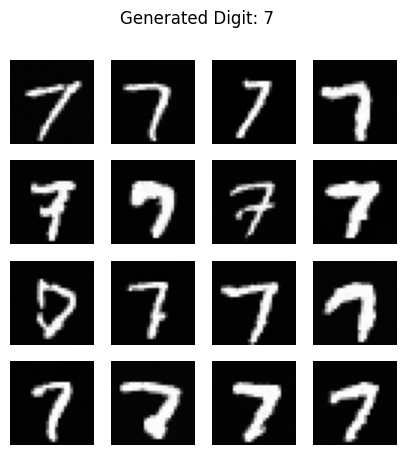

In [ ]:
target_digit = 7
y = torch.full((16,), target_digit, device=device, dtype=torch.long)

gen = sample(16, y=y)

plt.figure(figsize=(5,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(gen[i,0].cpu(), cmap="gray")
    plt.axis("off")

plt.suptitle(f"Generated Digit: {target_digit}")
plt.show()


# text to new gen. image  >> Stable Diffusion